<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/v1/states/daily.json"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))
dfCovidtracking.set_index(['date'], inplace=True)


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/06-07-2020.csv"


dfJHUData = pd.read_csv(jhurl, header=0, usecols=[0,1,2,3,4,5,6,7,8,9,10,11],
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [94]:
print("US Summary")
dfCovidtracking.groupby(by='date').sum()[-3:][['positive', 'death', 'positiveIncrease', 'deathIncrease']]

US Summary


,positive,death,positiveIncrease,deathIncrease
date,,,,
2020-06-05,1893167,103201,28392,1100
2020-06-06,1916229,103947,23062,746
2020-06-07,1936161,104400,19932,453


In [95]:
dfCovidtracking.loc[dfCovidtracking.state=='CA'].groupby(by='date').sum()[['positive', 'death', 'positiveIncrease', 'deathIncrease']].tail()

,positive,death,positiveIncrease,deathIncrease
date,,,,
2020-06-03,117687,4361,2377,75
2020-06-04,119807,4422,2120,61
2020-06-05,122901,4485,3094,63
2020-06-06,126016,4559,3115,74
2020-06-07,128812,4626,2796,67


In [96]:
dfctd_state_curr = dfCovidtracking.loc[dfCovidtracking.index.max()] \
  .rename(columns={'positive':'total_positive'}) \
  .set_index('state') 

print(f"Total positive cases = {dfctd_state_curr.total_positive.sum()}")
print(f"Total deaths = {dfctd_state_curr.death.sum()}")
  
dfctd_state_curr.sort_values(by='total_positive', ascending=False).head(5)

Total positive cases = 1936161
Total deaths = 104400


,total_positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NY,378097,2119745,0,2427.0,89995.0,704.0,0.0,534.0,0.0,67544.0,A,6/7/2020 00:00,2020-06-07T00:00:00Z,06/06 20:00,24259,89995.0,2020-06-07T00:00:00Z,36,781,59654,2497842,2497842,60435,2497842,47,0,b356fda1238193c617f971ca43fd5d3318a3debb,0,0,0,0,0,
NJ,164164,796261,0,1882.0,18050.0,503.0,0.0,385.0,0.0,27824.0,A+,6/7/2020 13:00,2020-06-07T13:00:00Z,06/07 09:00,12176,18050.0,2020-06-07T13:00:00Z,34,271,40706,960425,960425,40977,960425,70,27,4772e34066f939a6ed7d7635610784cb729f69e7,0,0,0,0,0,
CA,128812,2233406,0,4525.0,0.0,1288.0,0.0,0.0,0.0,0.0,B,6/7/2020 00:00,2020-06-07T00:00:00Z,06/06 20:00,4626,0.0,2020-06-07T00:00:00Z,06,2796,51122,2362218,2362218,53918,2362218,67,0,c488c7b5e4d006a61717e637d445fcb324f8e1ee,0,0,0,0,0,
IL,127757,915017,0,2550.0,0.0,720.0,0.0,438.0,0.0,0.0,A,6/7/2020 00:59,2020-06-07T00:59:00Z,06/06 20:59,5904,0.0,2020-06-07T00:59:00Z,17,867,19833,1042774,1042774,20700,1042774,40,0,0af8abf46c6e14b8cf5a19b87444b92a8f87225e,0,0,0,0,0,
MA,103436,549054,0,1442.0,10393.0,335.0,0.0,221.0,0.0,0.0,A+,6/7/2020 10:00,2020-06-07T10:00:00Z,06/07 06:00,7316,10393.0,2020-06-07T10:00:00Z,25,304,7547,652490,652490,7851,652490,27,24,f996cd5a453a43e90c08671c5747f7084f2ffd67,0,0,0,0,0,


In [0]:
curr_state = 'CA'
gbUSA = dfCovidtracking.groupby(['date'])
gbState = dfCovidtracking[dfCovidtracking.state==curr_state].groupby(['date'])

cols = ['positive', 'totalTestResults', 'death', 'positiveIncrease','deathIncrease']

dfUSAPos = gbUSA[cols].sum().reset_index().copy()
dfStatePos = gbState[cols].sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 

dfUSAPos['pos_pct']= dfUSAPos.positive/dfctd_state_curr.total_positive.sum()
dfStatePos['pos_pct']=dfStatePos.positive/dfctd_state_curr.loc[curr_state].total_positive

In [98]:
dfUSAPos[-7:]


,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,pos_pct
131,2020-06-01,1800662,17364135,99078,16084,478,0.930017
132,2020-06-02,1824172,17783959,100246,23510,1168,0.942159
133,2020-06-03,1844235,18242750,101217,20063,971,0.952522
134,2020-06-04,1864775,18702684,102101,20540,884,0.963130
135,2020-06-05,1893167,19248374,103201,28392,1100,0.977794
136,2020-06-06,1916229,19788527,103947,23062,746,0.989705
137,2020-06-07,1936161,20235678,104400,19932,453,1.000000


In [99]:
dfStatePos[-7:]

,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,pos_pct
89,2020-06-01,113006,2012583,4251,2423,38,0.877294
90,2020-06-02,115310,2071591,4286,2304,35,0.895181
91,2020-06-03,117687,2131294,4361,2377,75,0.913634
92,2020-06-04,119807,2182671,4422,2120,61,0.930092
93,2020-06-05,122901,2238463,4485,3094,63,0.954111
94,2020-06-06,126016,2308300,4559,3115,74,0.978294
95,2020-06-07,128812,2362218,4626,2796,67,1.000000


In [100]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
date,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-03,1844235,16398515,3556,32081.0,216640.0,7224.0,8688.0,3749.0,717.0,479258.0,101217,216640.0,20063,438728,18246306,18242750,458791,18242750,971,2258,0,0,0,0,0
2020-06-04,1864775,16837909,3474,31659.0,213812.0,7054.0,8787.0,3665.0,723.0,485002.0,102101,213812.0,20540,439394,18706158,18702684,459934,18702684,884,-2828,0,0,0,0,0
2020-06-05,1893167,17355207,1749,31335.0,215252.0,6912.0,8863.0,3523.0,740.0,491706.0,103201,215252.0,28392,517298,19250123,19248374,545690,19248374,1100,1440,0,0,0,0,0
2020-06-06,1916229,17872298,1796,30909.0,216259.0,6754.0,8920.0,3476.0,750.0,500849.0,103947,216259.0,23062,517091,19790323,19788527,540153,19788527,746,1007,0,0,0,0,0
2020-06-07,1936161,18299517,1733,30299.0,216906.0,6493.0,8957.0,3298.0,753.0,506367.0,104400,216906.0,19932,427219,20237411,20235678,447151,20235678,453,647,0,0,0,0,0


In [101]:
gbState.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
date,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-03,117687,2013607,0,4458.0,0.0,1313.0,0.0,0.0,0.0,0.0,4361,0.0,2377,57326,2131294,2131294,59703,2131294,75,0,0,0,0,0,0
2020-06-04,119807,2062864,0,4455.0,0.0,1279.0,0.0,0.0,0.0,0.0,4422,0.0,2120,49257,2182671,2182671,51377,2182671,61,0,0,0,0,0,0
2020-06-05,122901,2115562,0,4625.0,0.0,1333.0,0.0,0.0,0.0,0.0,4485,0.0,3094,52698,2238463,2238463,55792,2238463,63,0,0,0,0,0,0
2020-06-06,126016,2182284,0,4526.0,0.0,1315.0,0.0,0.0,0.0,0.0,4559,0.0,3115,66722,2308300,2308300,69837,2308300,74,0,0,0,0,0,0
2020-06-07,128812,2233406,0,4525.0,0.0,1288.0,0.0,0.0,0.0,0.0,4626,0.0,2796,51122,2362218,2362218,53918,2362218,67,0,0,0,0,0,0


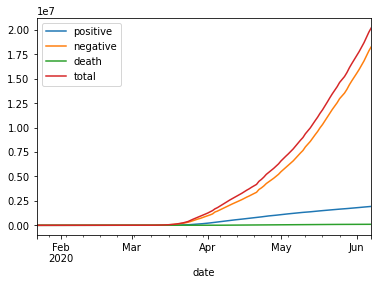

In [102]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

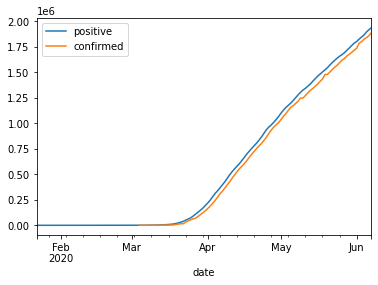

In [103]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

# John Hopkins Data


In [182]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    1942363
dead          110514
dtype: int64

In [105]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    128593
dead           4606
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [107]:
dfJHUData.head()

,FIPS,city,state,country,last_update,lat,lon,confirmed,dead,recovered,active,key
0,45001.0,Abbeville,South Carolina,US,2020-06-07 03:53:30,34.223334,-82.461707,47,0,0,47,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-06-07 03:53:30,30.295065,-92.414197,500,27,0,473,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-06-07 03:53:30,37.767072,-75.632346,970,13,0,957,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-06-07 03:53:30,43.452658,-116.241552,838,22,0,816,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-06-07 03:53:30,41.330756,-94.471059,9,0,0,9,"Adair, Iowa, US"


In [108]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                1920061
Brazil             672846
Russia             458102
United Kingdom     286294
India              246622
Spain              241310
Italy              234801
Peru               191758
France             190759
Germany            185450
Name: confirmed, dtype: int64

In [109]:
dfctd_state_curr.head()

,total_positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AK,544,64360,0,7.0,0.0,0.0,0.0,1.0,0.0,382.0,B,6/7/2020 00:00,2020-06-07T00:00:00Z,06/06 20:00,10,0.0,2020-06-07T00:00:00Z,02,8,995,64904,64904,1003,64904,0,-48,62adbd451838656b7df7519e830d6439be0b5877,0,0,0,0,0,
AL,20500,239066,0,0.0,2022.0,0.0,615.0,0.0,364.0,11395.0,B,6/7/2020 11:00,2020-06-07T11:00:00Z,06/07 07:00,692,2022.0,2020-06-07T11:00:00Z,01,457,13465,259566,259566,13922,259566,3,29,9040674078ce6afca363f8e95943845a032ab5d6,0,0,0,0,0,
AR,9426,150847,0,145.0,844.0,0.0,0.0,35.0,143.0,6424.0,A,6/7/2020 16:10,2020-06-07T16:10:00Z,06/07 12:10,154,844.0,2020-06-07T16:10:00Z,05,325,3191,160273,160273,3516,160273,0,6,ef23d4d3f9e232bb5f58a59d79a27d2cb0797e2a,0,0,0,0,0,
AS,0,174,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C,6/1/2020 00:00,2020-06-01T00:00:00Z,05/31 20:00,0,0.0,2020-06-01T00:00:00Z,60,0,0,174,174,0,174,0,0,893135d0d7a9340a91aca139f4e3bb289f418f71,0,0,0,0,0,
AZ,26889,254732,0,1252.0,3352.0,392.0,0.0,248.0,0.0,5517.0,A+,6/7/2020 00:00,2020-06-07T00:00:00Z,06/06 20:00,1044,3352.0,2020-06-07T00:00:00Z,04,1438,8537,281621,281621,9975,281621,2,32,505a05efa5a9b912644a7ad16b2ab6f37330806b,0,0,0,0,0,


In [0]:
dfState = dfCovidtracking.reset_index()[['date','state','positive', 'death']].set_index('state') \
  .join(dfctd_state_curr.total_positive)

In [0]:
dfState['pct']=dfState.positive/dfState.total_positive

In [112]:
dfState.loc['FL'].head(14)


,date,positive,death,total_positive,pct
state,,,,,
FL,2020-06-07,63938,2786,63938,1.000000
FL,2020-06-06,62758,2773,63938,0.981545
FL,2020-06-05,61488,2745,63938,0.961682
FL,2020-06-04,60183,2691,63938,0.941271
FL,2020-06-03,58764,2650,63938,0.919078
FL,2020-06-02,57447,2613,63938,0.898480
FL,2020-06-01,56830,2543,63938,0.888830
FL,2020-05-31,56163,2534,63938,0.878398
FL,2020-05-30,55424,2530,63938,0.866840


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

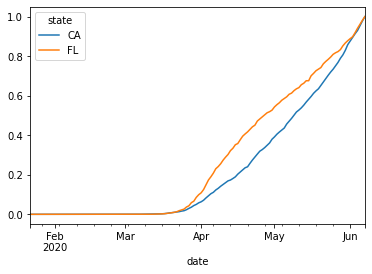

In [114]:
x = res.loc[:, ['CA','FL']].plot.line()

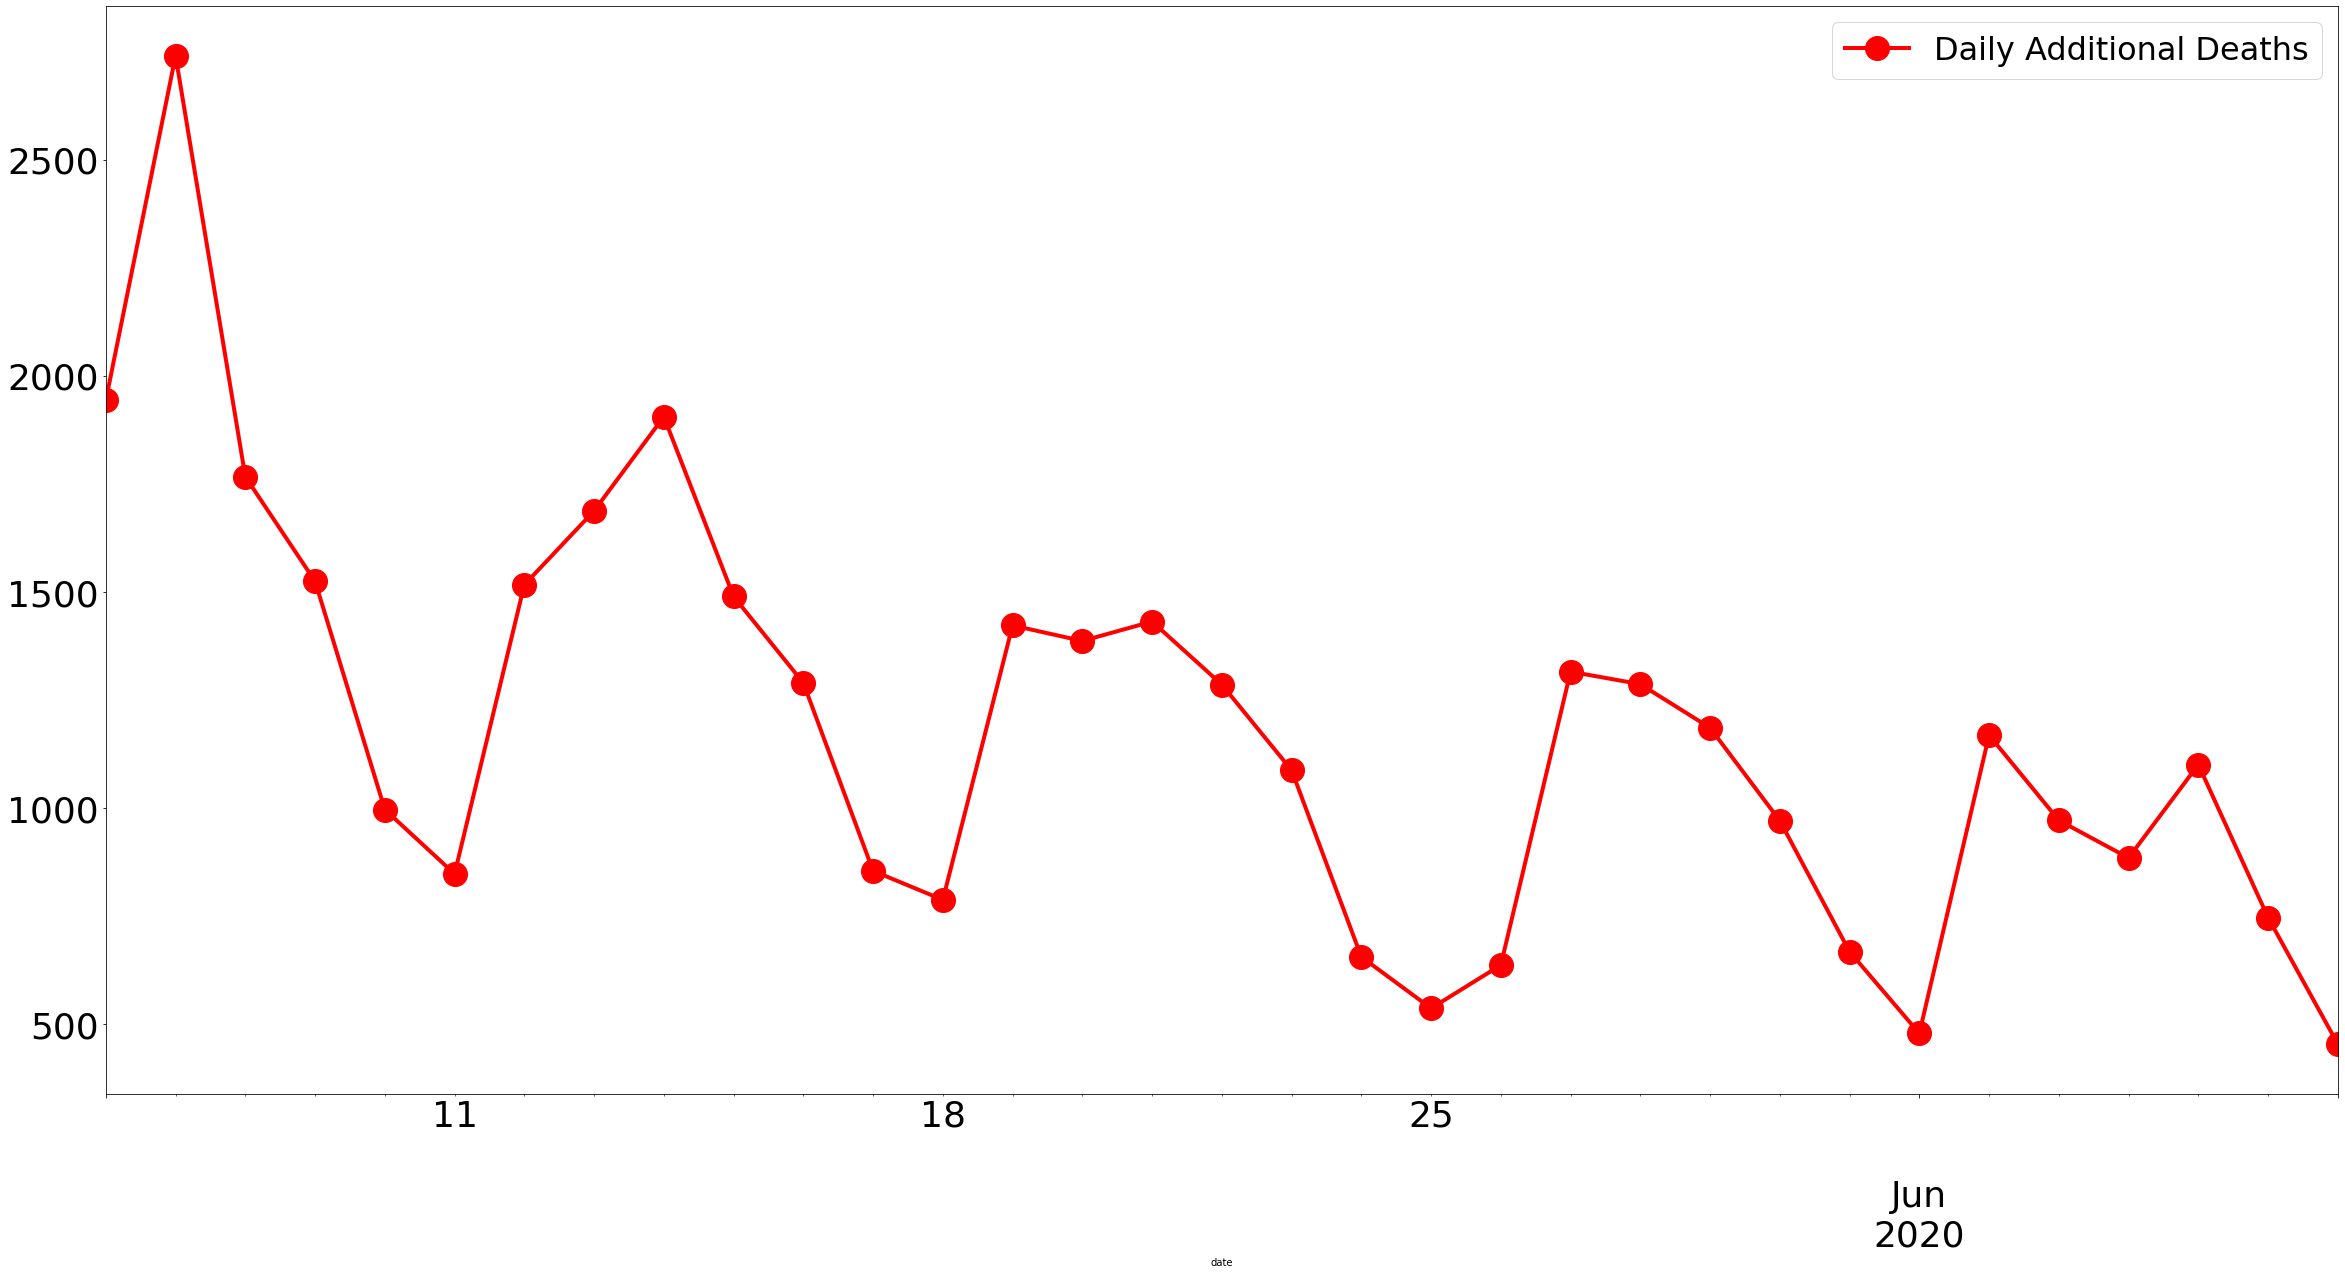

In [115]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()[-33:].deathIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Deaths'],fontsize=32)


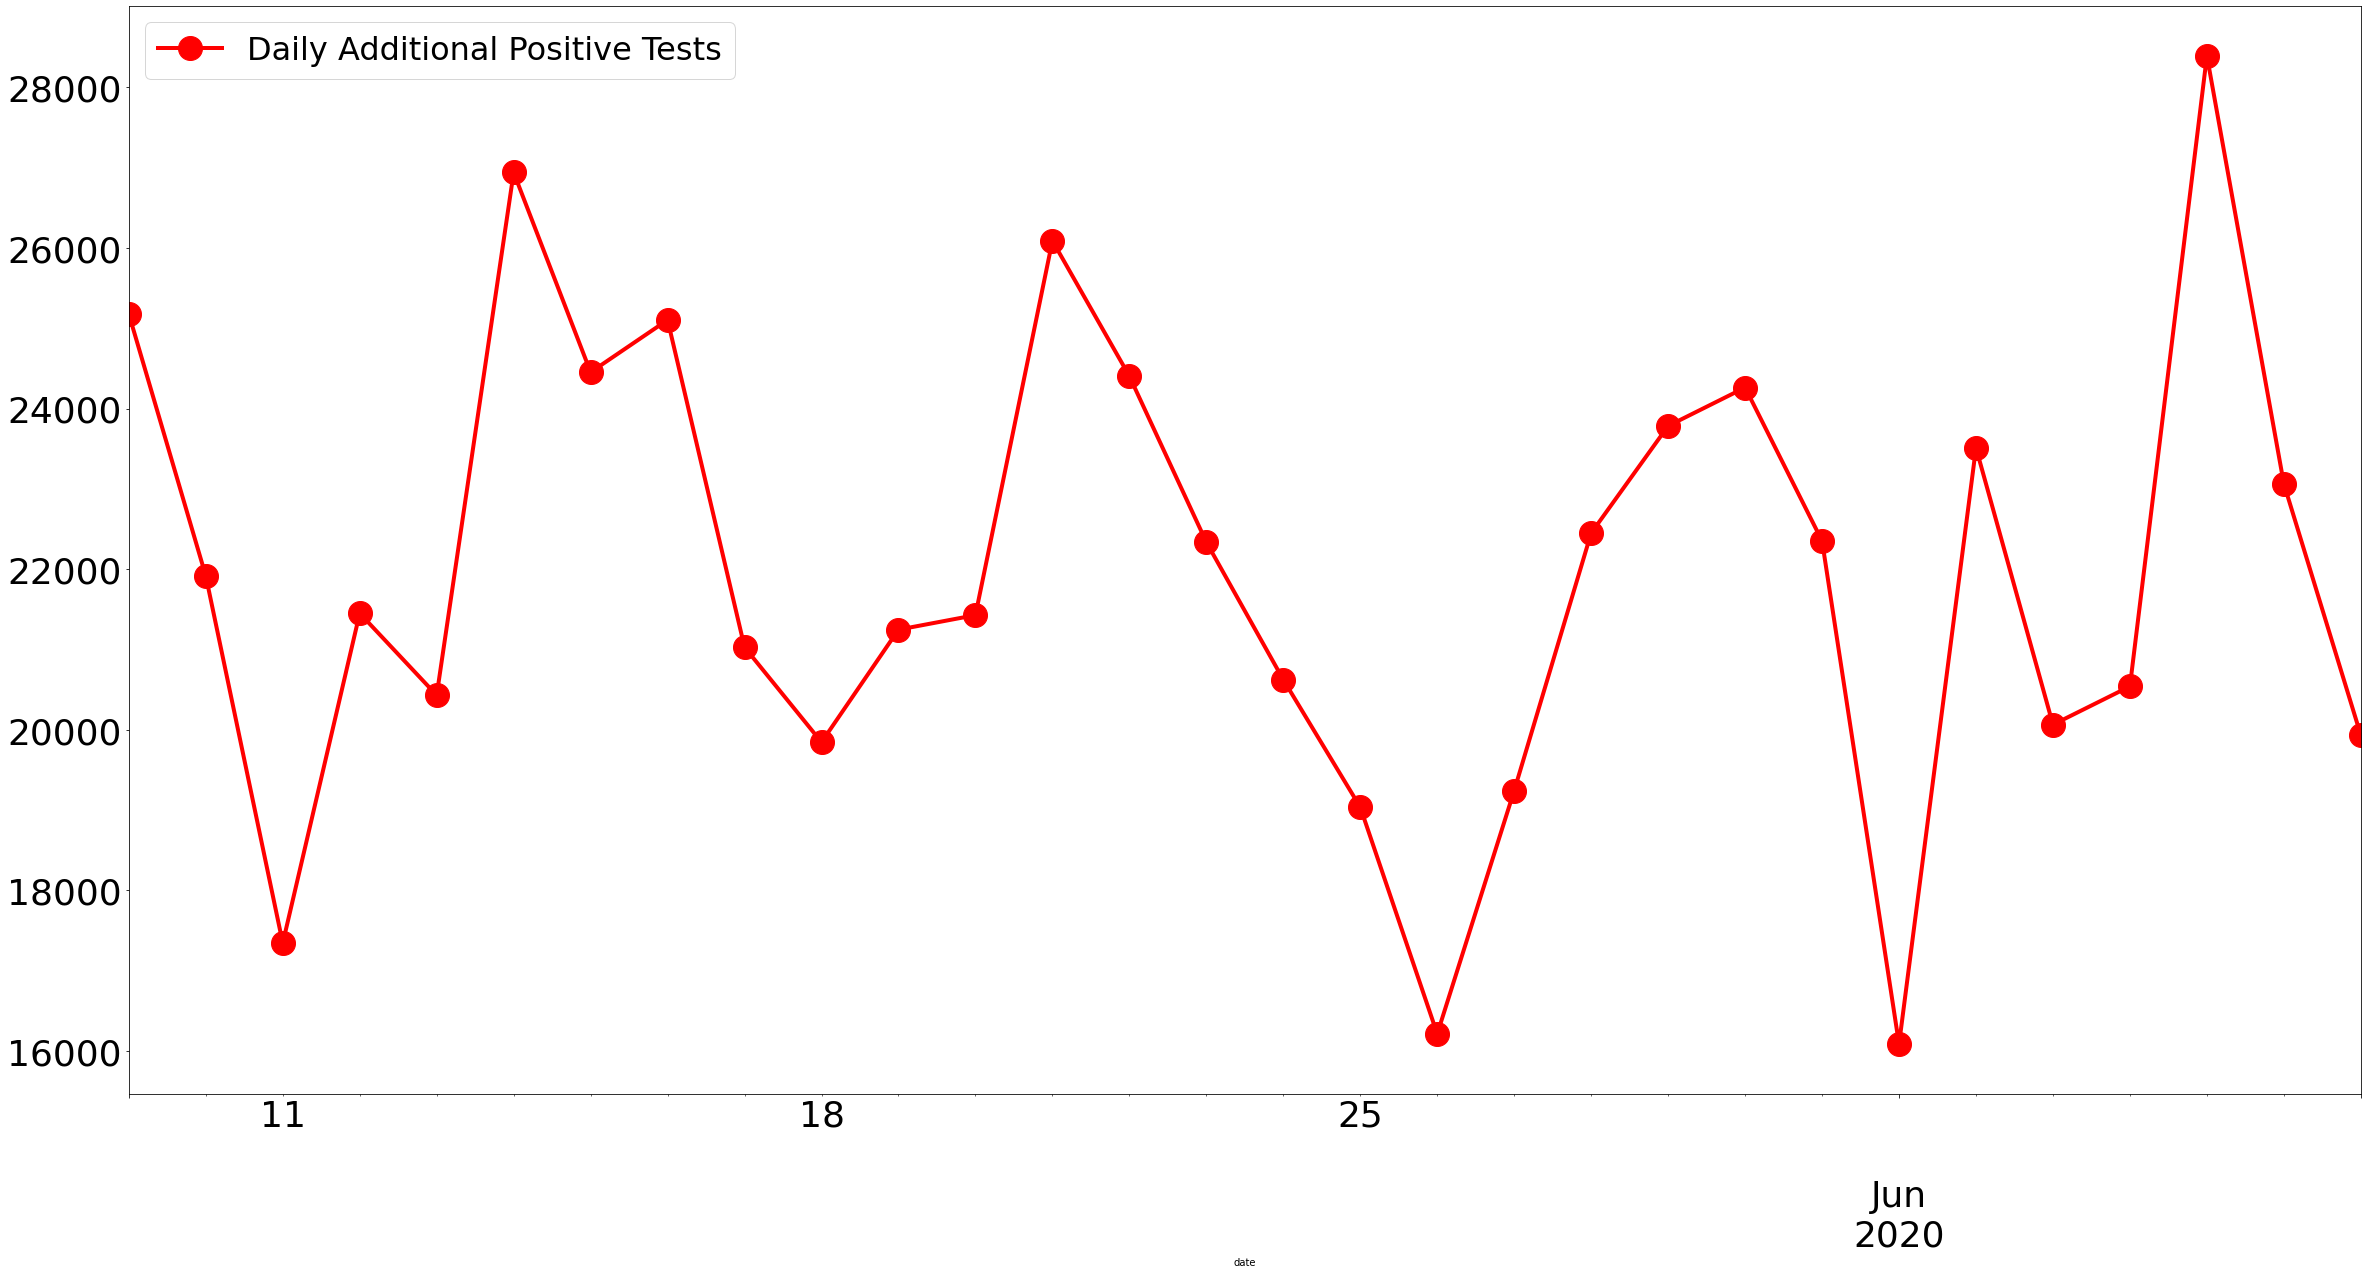

In [116]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()

chart = y1[-30:].positiveIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Positive Tests'],fontsize=32)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfByWeekYear = dfCovidtracking[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=getWeek)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfDoW = dfCovidtracking[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=lambda x: x.dayofweek)


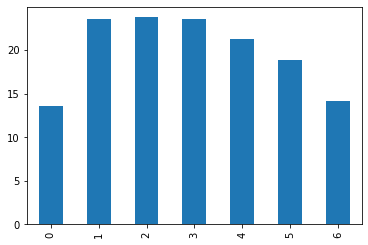

In [119]:
dfDoW.mean().deathIncrease.plot.bar()



In [120]:
dfByWeekYear.sum()[-7:]

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
202017,12877,18476,1320186,209017,1529203
202018,12704,24581,1464857,191823,1656680
202019,12406,18998,1739843,170932,1910775
202020,9587,12129,2326573,156743,2483316
202021,8053,15648,2565379,155969,2721348
202022,6595,26480,2622855,147333,2770188
202023,5800,6823,3124121,151583,3275704


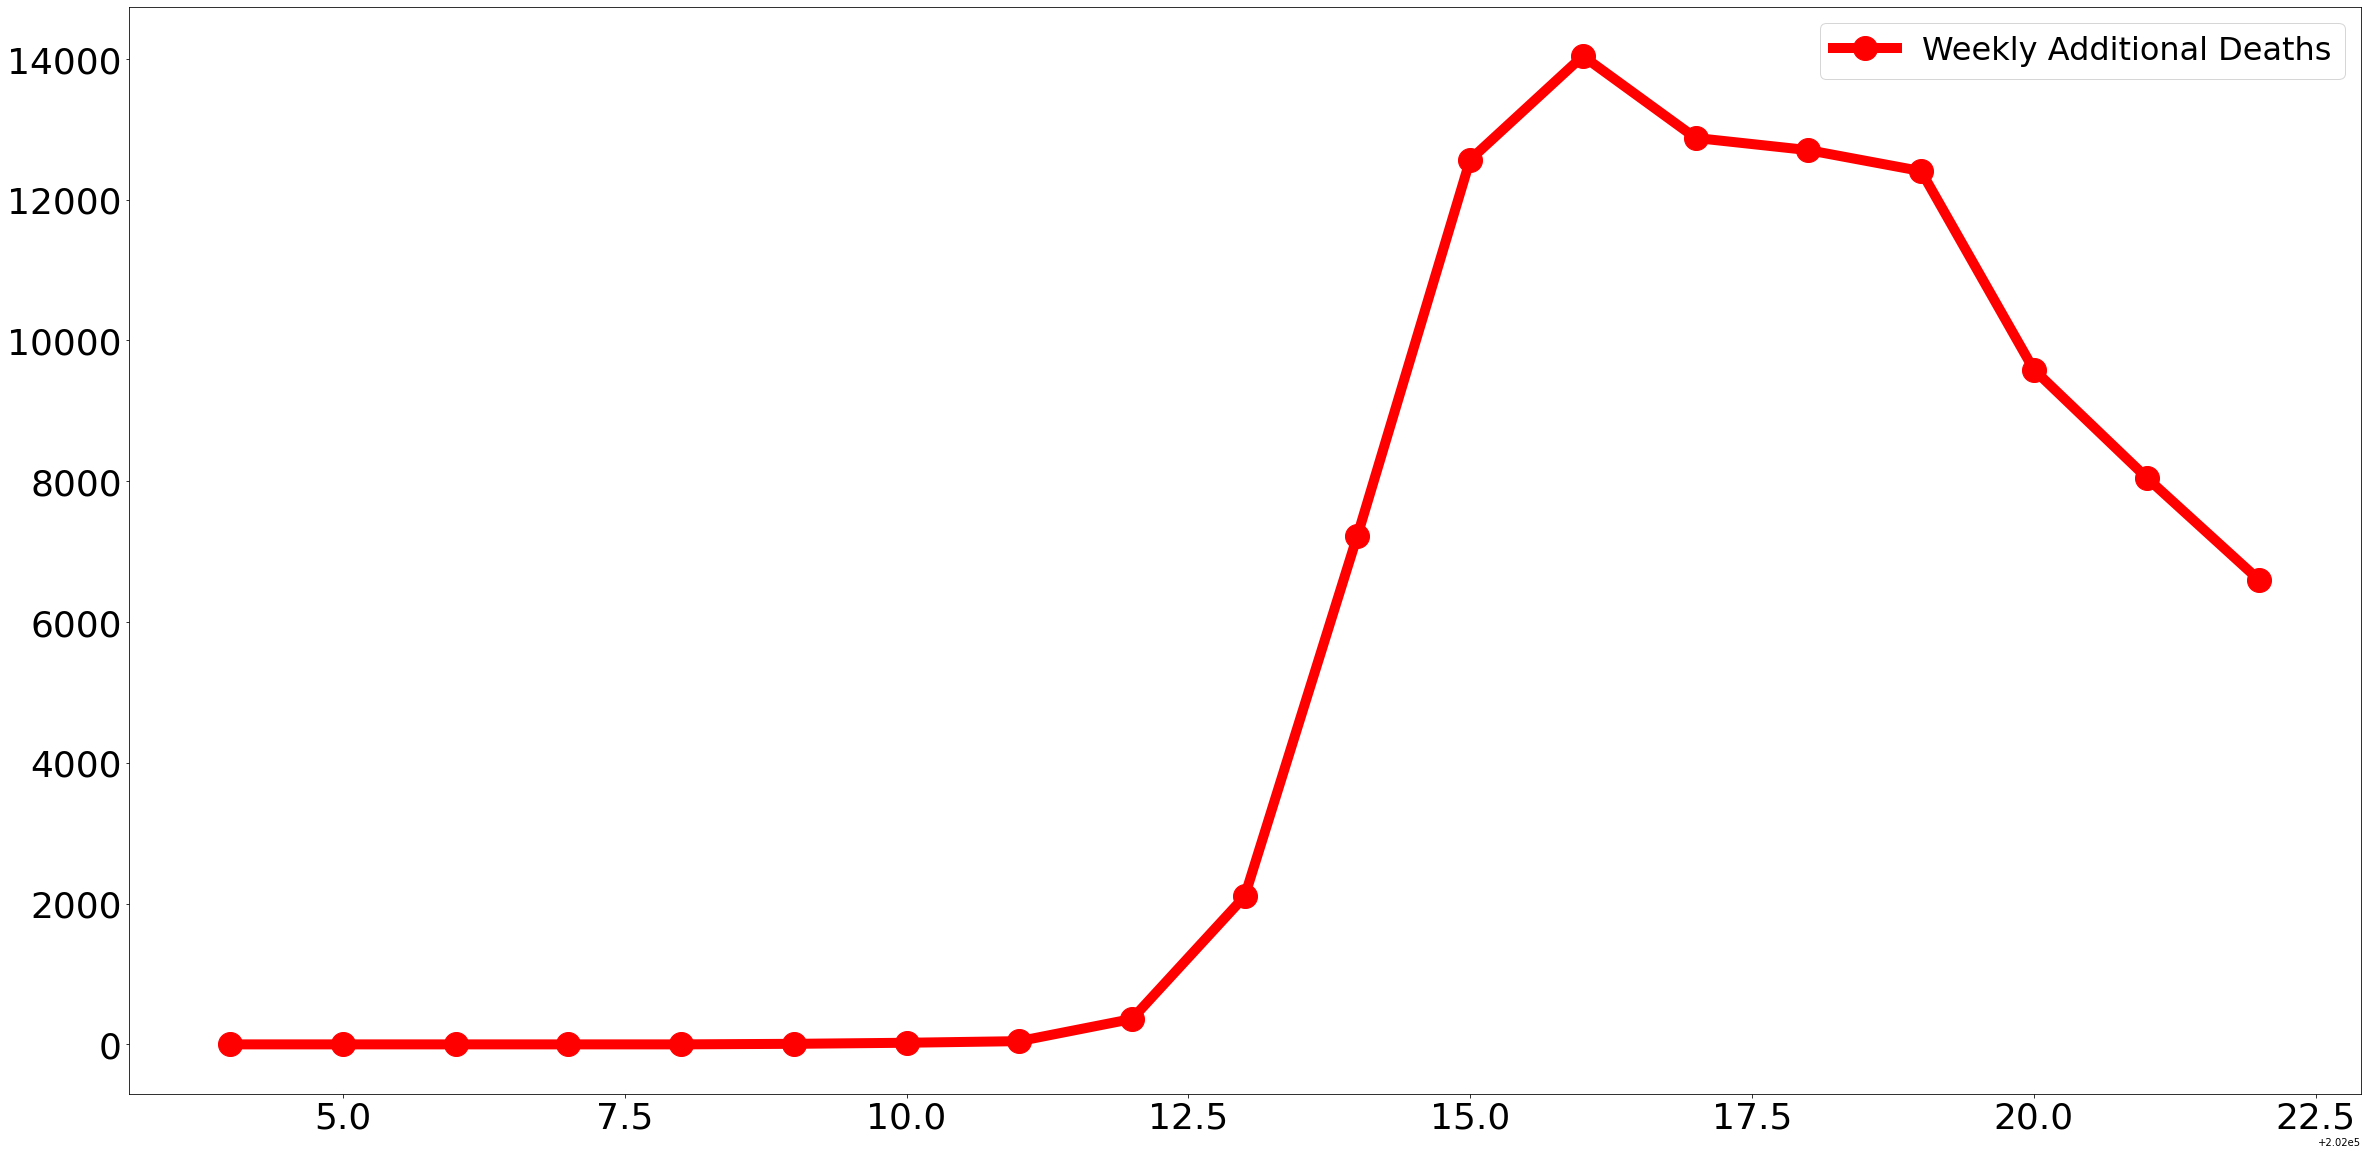

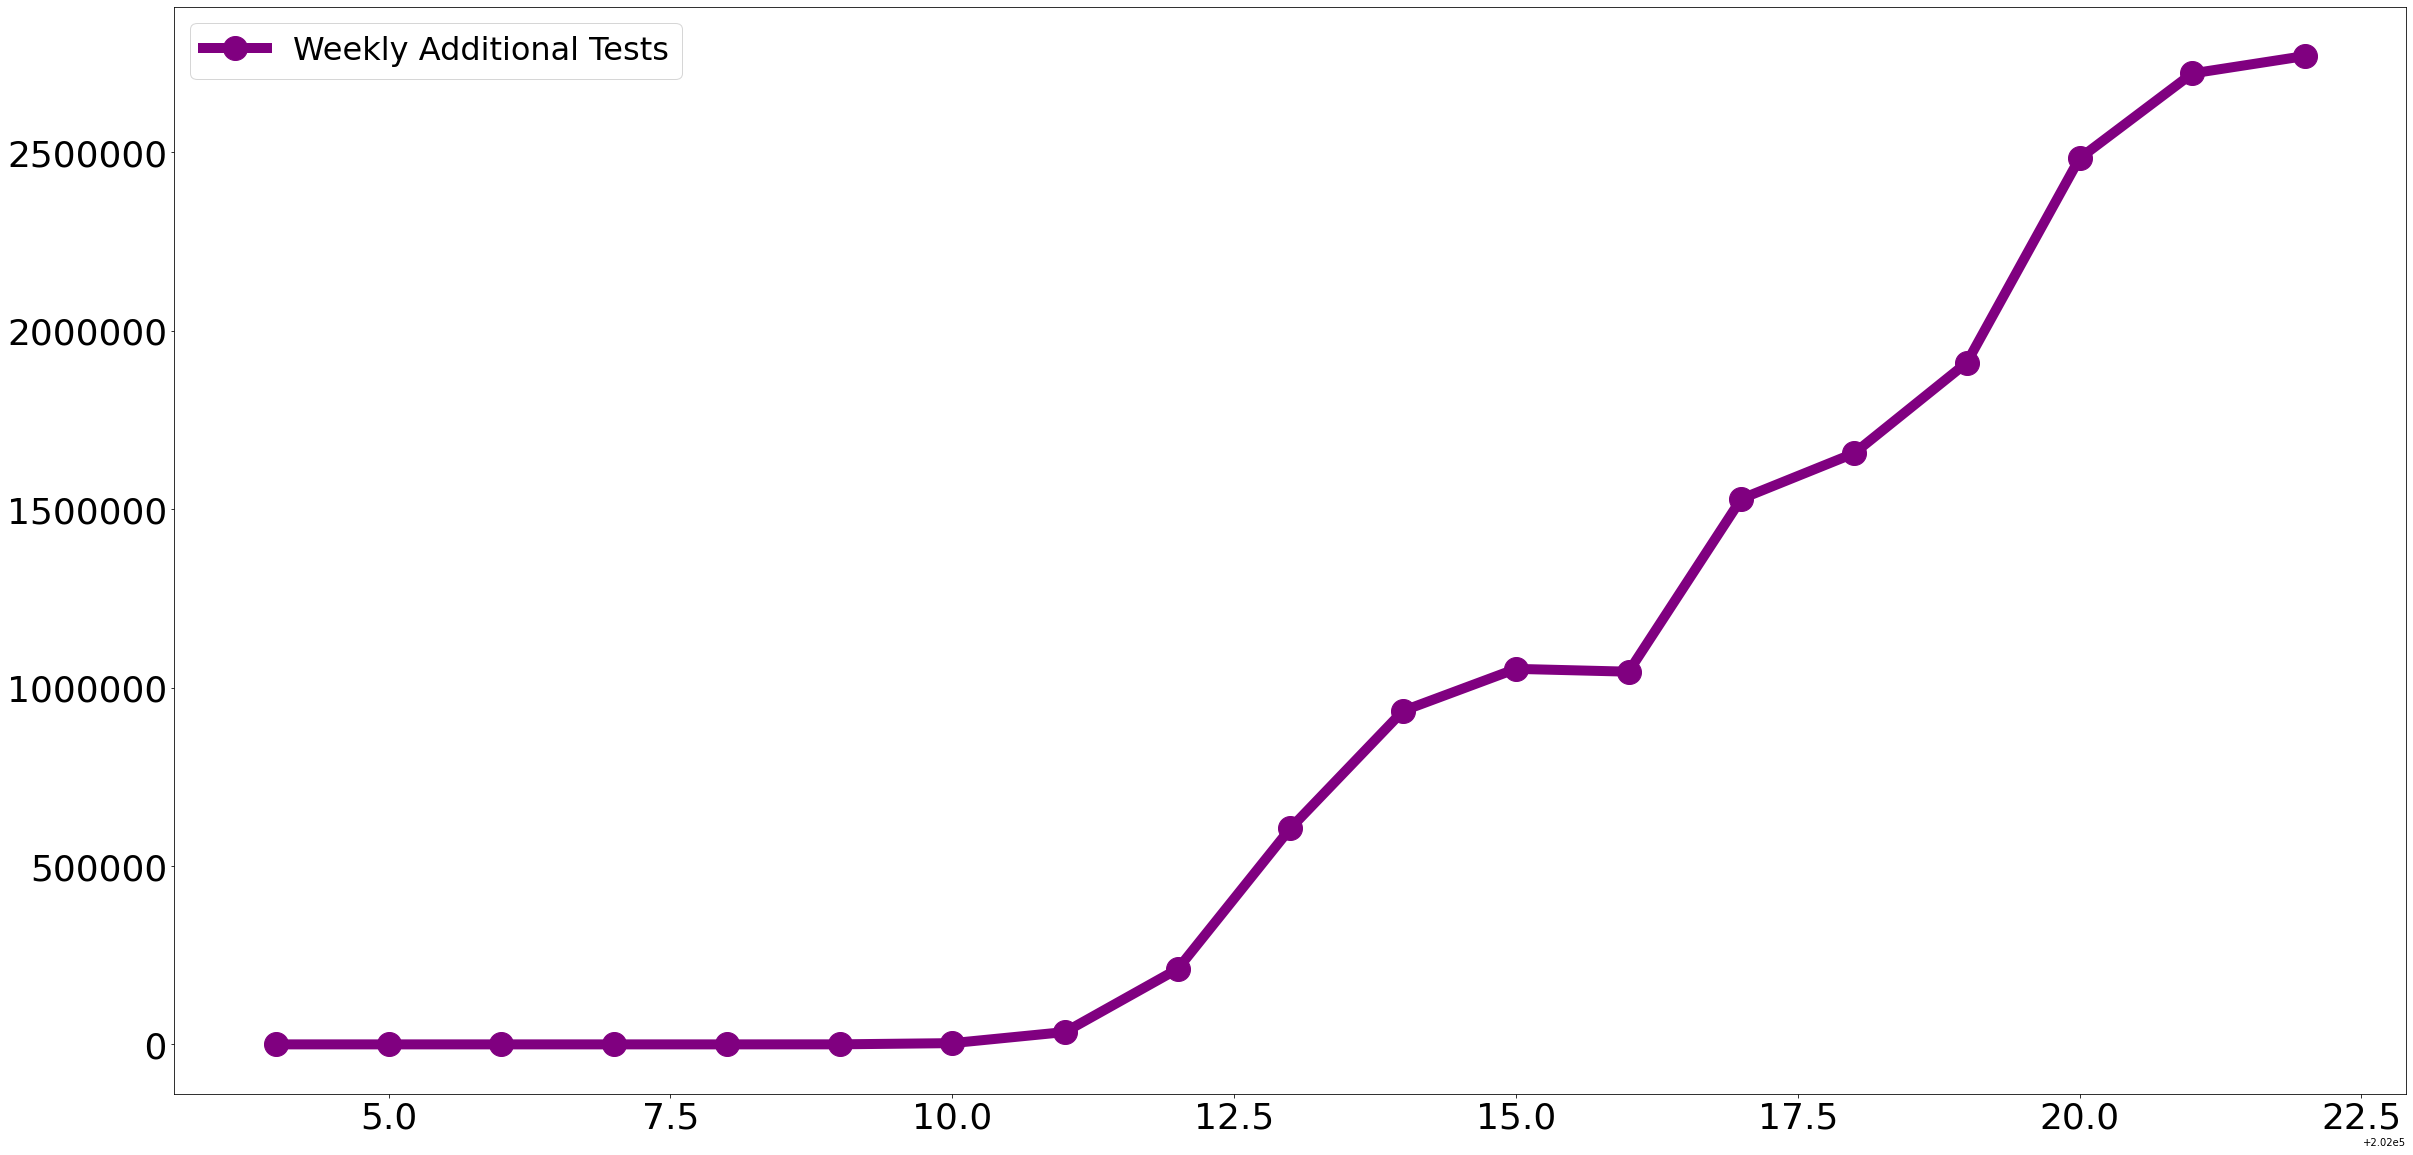

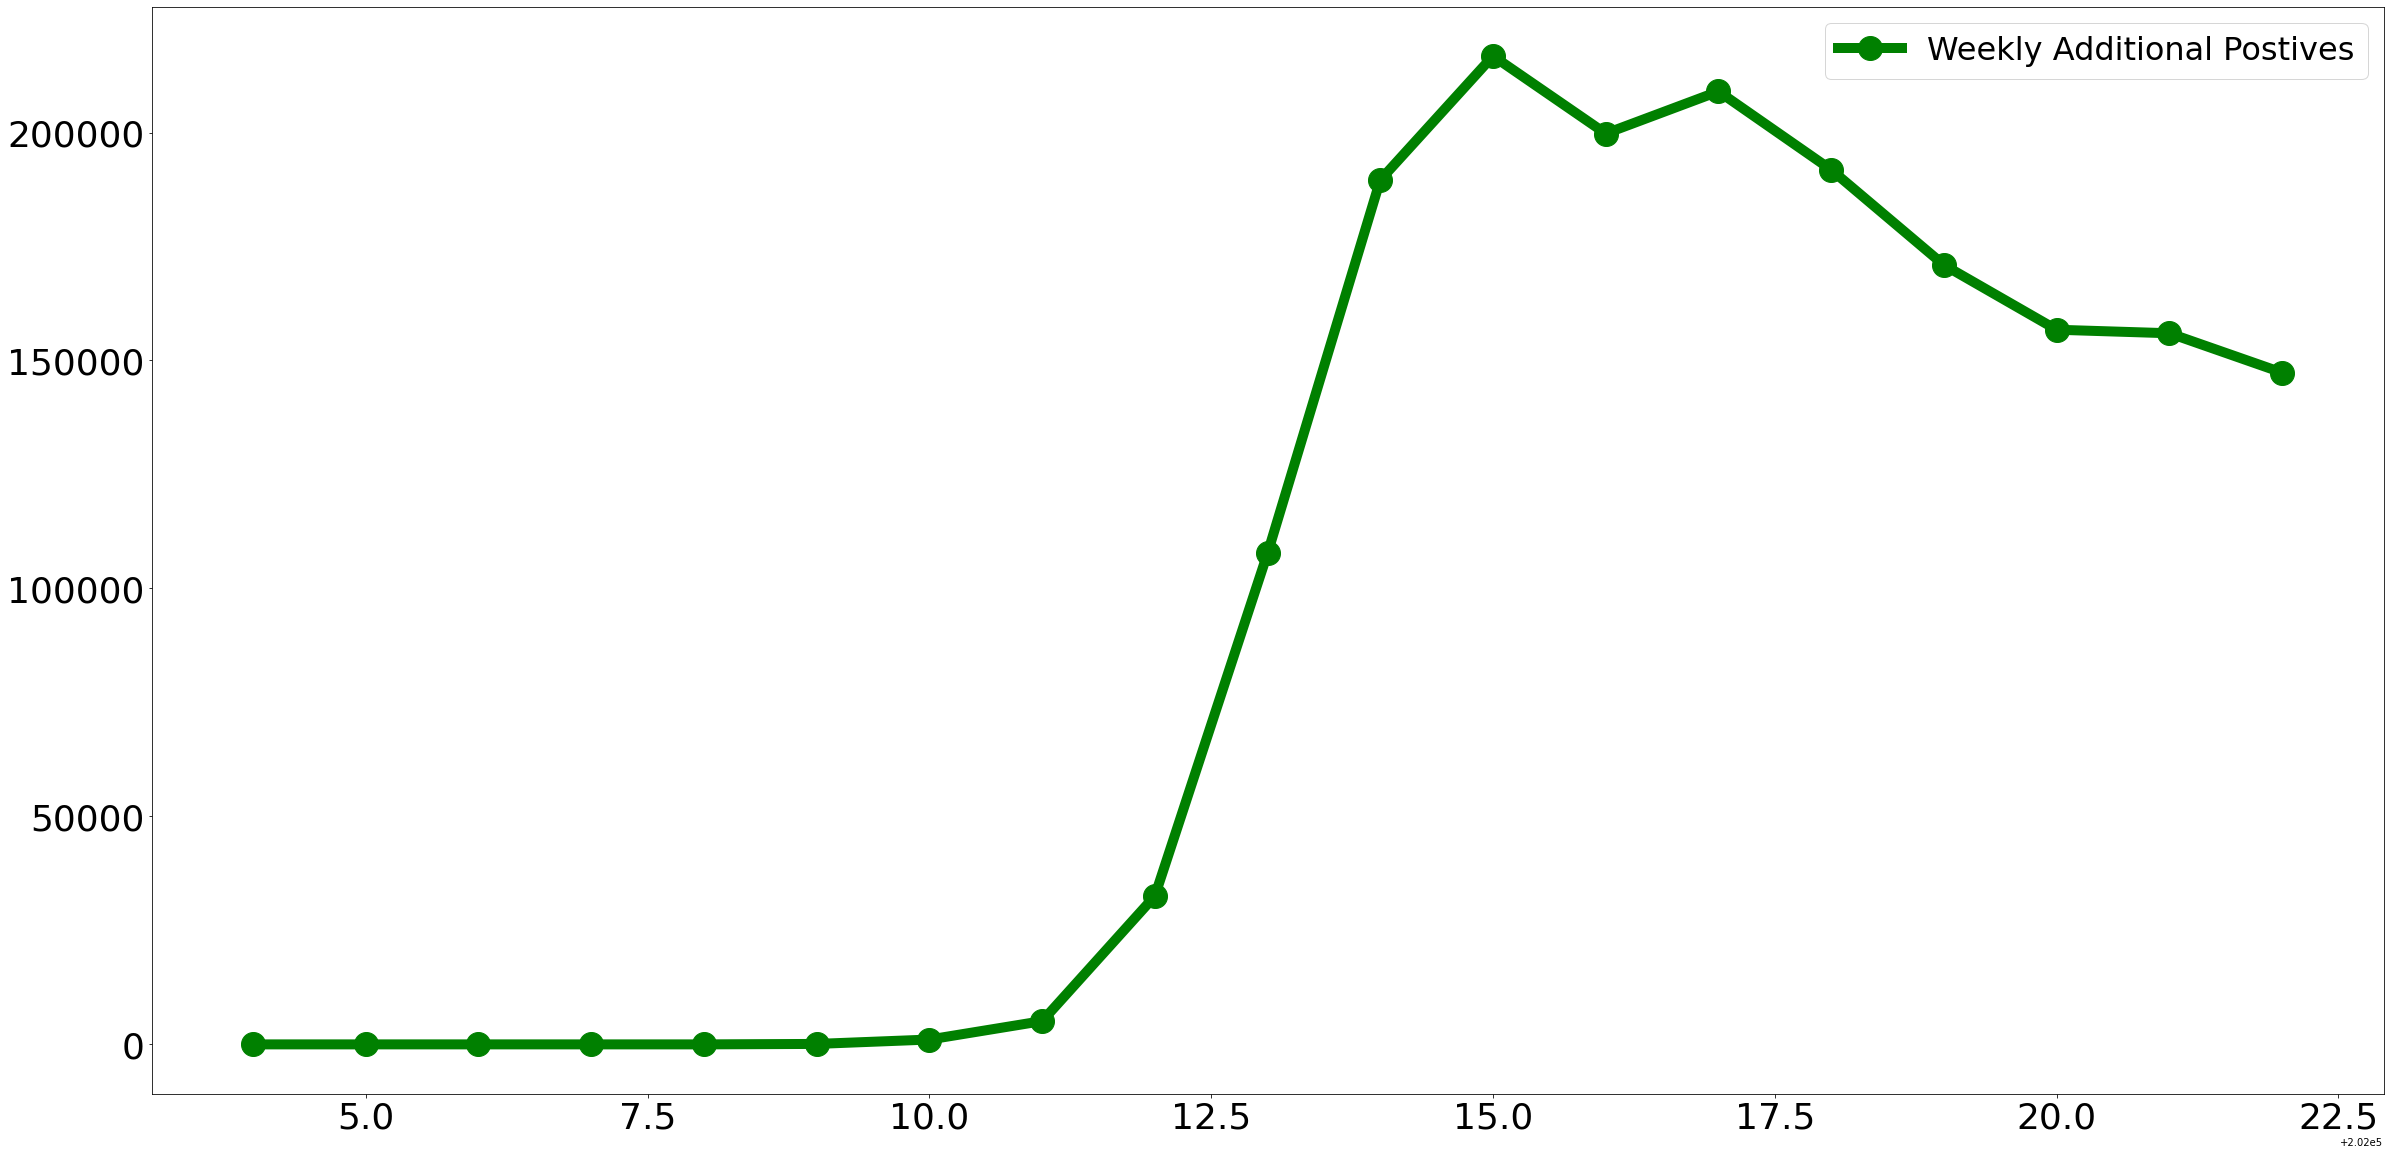

In [121]:
import matplotlib.ticker as ticker
plt1 = dfByWeekYear.sum()[:-1][['deathIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='red')
plt1.legend(['Weekly Additional Deaths'],fontsize=32)
plt2 = dfByWeekYear.sum()[:-1][['totalTestResultsIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='purple')
plt2.legend(['Weekly Additional Tests'],fontsize=32)

plt2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%6.0d'))
    
plt3 = dfByWeekYear.sum()[:-1][['positiveIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='green')
plt3.legend(['Weekly Additional Postives'],fontsize=32)

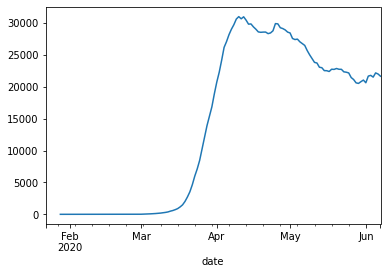

In [122]:
dfCovidtracking.groupby(by='date').sum().rolling(window=7).mean().positiveIncrease.plot.line()

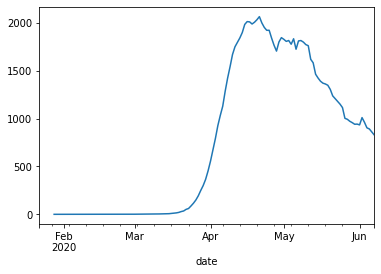

In [123]:
dfCovidtracking.groupby(by='date').sum().rolling(window=7).mean().deathIncrease.plot.line()

In [0]:
dfCAAvg = dfCovidtracking[dfCovidtracking.state=='CA'] \
.groupby(by='date').sum().rolling(window=7).mean()

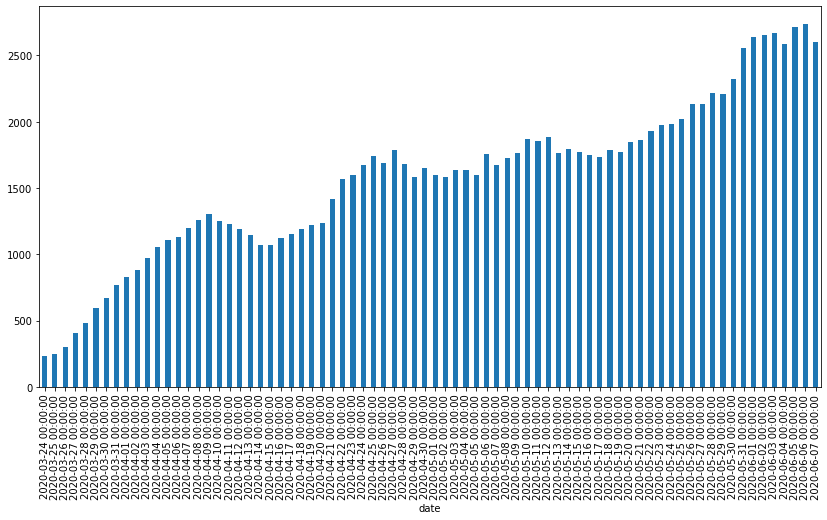

In [125]:

graph1 = dfCAAvg[20:].positiveIncrease.plot.bar(figsize=(14,7))


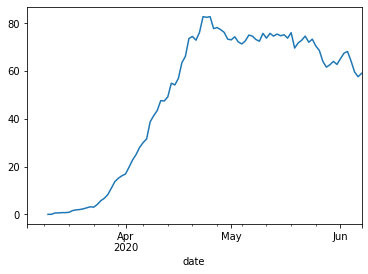

In [126]:
dfCAAvg.deathIncrease.plot.line()

In [127]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['TN']))].head(10)

,state,date,positive,death,total_positive,pct
4303,TN,2020-06-07,26381,418,26381,1.000000
4304,TN,2020-06-06,26071,417,26381,0.988249
4305,TN,2020-06-05,25520,408,26381,0.967363
4306,TN,2020-06-04,25120,401,26381,0.952200
4307,TN,2020-06-03,24822,388,26381,0.940904
4308,TN,2020-06-02,24375,381,26381,0.923960
4309,TN,2020-06-01,23554,367,26381,0.892840
4310,TN,2020-05-31,23006,364,26381,0.872067
4311,TN,2020-05-30,22566,364,26381,0.855388
4312,TN,2020-05-29,22085,360,26381,0.837156


In [128]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=7)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .85)].sort_values(by='pct')


,state,date,positive,death,total_positive,pct
372,AZ,2020-05-31,19936,906,26889,0.741418
3938,PR,2020-05-31,3776,136,4985,0.757472
194,AR,2020-05-31,7253,133,9426,0.769467
7,AK,2020-05-31,434,10,544,0.797794
2800,NC,2020-05-31,28589,886,35546,0.804282
4501,UT,2020-05-31,9797,113,12066,0.811951
2530,MP,2020-05-31,22,2,27,0.814815
4121,SC,2020-05-31,11861,494,14286,0.830253


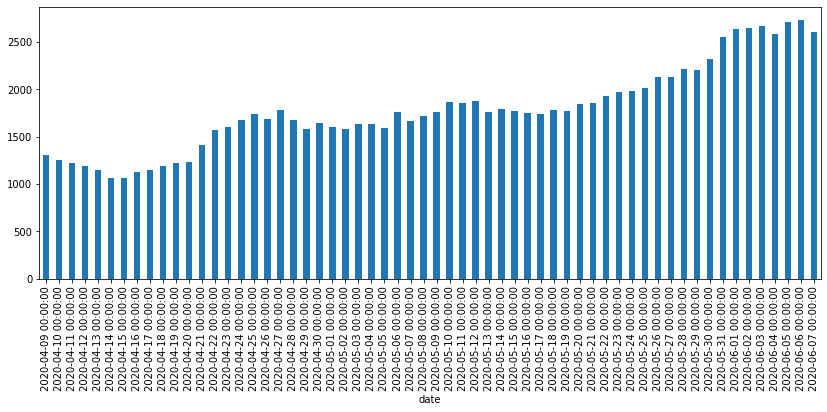

In [129]:

def showStateData(state):
  return dfCovidtracking[dfCovidtracking.state==state]\
  .sort_index()\
  .copy()



chart = showStateData('CA')\
.positiveIncrease\
.rolling(window=7)\
.mean()[-60:].plot.bar(figsize=(14,5))

In [130]:
dfTest = dfCovidtracking[dfCovidtracking.state=='CA'].sort_index().copy()
dfTest.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-04,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,06,0,0,515,515,0,515,0,0,ae2b9d2e5d691c66d1abe7c43c3564e865279fd9,0,0,0,0,0,
2020-03-05,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,06,0,0,515,515,0,515,0,0,10c1ce97af2a37d316e43bb512b486d8c380ca37,0,0,0,0,0,
2020-03-06,CA,60,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,06,7,0,522,522,7,522,0,0,2790f2f9e9ab3cc94caca4b0a2c7d0ecb23ddcf6,0,0,0,0,0,
2020-03-07,CA,69,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,06,9,0,531,531,9,531,0,0,af5f339fc3168c1f9135ea735ef21475b35a8c01,0,0,0,0,0,
2020-03-08,CA,88,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,06,19,0,550,550,19,550,0,0,bcf5160531e8ce70a9a61aa770e6aa4e869161ef,0,0,0,0,0,


In [131]:
dfTest.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-04,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,06,0,0,515,515,0,515,0,0,ae2b9d2e5d691c66d1abe7c43c3564e865279fd9,0,0,0,0,0,
2020-03-05,CA,53,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,06,0,0,515,515,0,515,0,0,10c1ce97af2a37d316e43bb512b486d8c380ca37,0,0,0,0,0,
2020-03-06,CA,60,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,06,7,0,522,522,7,522,0,0,2790f2f9e9ab3cc94caca4b0a2c7d0ecb23ddcf6,0,0,0,0,0,
2020-03-07,CA,69,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,06,9,0,531,531,9,531,0,0,af5f339fc3168c1f9135ea735ef21475b35a8c01,0,0,0,0,0,
2020-03-08,CA,88,462,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,06,19,0,550,550,19,550,0,0,bcf5160531e8ce70a9a61aa770e6aa4e869161ef,0,0,0,0,0,


# State Population Data


In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfUSPop = pd.read_csv(data_url)

In [134]:
import math
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.index.max()][['positive', 'negative', 'pending','death', 'total']].sum()
cir = res.positive/res.total
cfr = res.death/res.positive
p_aff= math.ceil(us_pop*cir)
p_dead= math.ceil(p_aff*cfr)
print(res)
print(f"Current Infection Rate {cir*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")
print(f"Observed CFR: {cfr*100:2f}%")
print(f"Percentage of US tested/affected: {(res.negative+res.positive+res.death)/us_pop*100:2f}%")
print(f"Projected affected by cir = {p_aff:,d}")
print(f"Projected killed = {p_dead:,d}")


positive     1936161
negative    18299517
pending         1733
death         104400
total       20237411
dtype: int64
Current Infection Rate 9.567237%
Percentage of US affected: 0.621668%
Observed CFR: 5.392114%
Percentage of US tested/affected: 6.196718%
Projected affected by cir = 31,403,452
Projected killed = 1,693,310


In [0]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [0]:
import us_state_abbrev as us_abbr


In [0]:
dfStatePop = dfUSPop[dfUSPop.STATE != 0].copy()

In [0]:
dfStatePop['ABBR']=dfStatePop.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [0]:
dfStatePop = dfStatePop.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfStatePop.set_index('ABBR', inplace=True)

In [0]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.index.max()].set_index('state')

In [0]:
dfStateJoin = dfStateCovid.join(dfStatePop)

In [142]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.totalTestResults/ dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).T.sort_values(by="state_pos_pop", ascending=False)[:51]

,state_pos_pop,state_test_pop
state,,
NY,1.943588,12.840025
NJ,1.848238,10.812930
MA,1.500703,9.466663
RI,1.457577,16.117169
DC,1.322283,7.728952
CT,1.233225,8.480495
DE,1.020987,7.085598
IL,1.008198,8.229078
MD,0.958916,6.034110


In [143]:
#print(f"Current Infection Rate {res.positive/res.total*100:2f}%")

print(f"Current Testing Percent {gbUSA.sum().tail(1).totalTestResults[0]/dfUSPop[dfUSPop.REGION=='0'].POPESTIMATE2019[0]*100:2f}%")

Current Testing Percent 6.164912%


In [144]:
dfJHUData.columns

Index(['FIPS', 'city', 'state', 'country', 'last_update', 'lat', 'lon',
       'confirmed', 'dead', 'recovered', 'active', 'key'],
      dtype='object')

# OWID Data

In [0]:
dfOwid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [146]:
dfOwid.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22452 entries, 0 to 22451
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   iso_code                         22388 non-null  object 
 1   continent                        22228 non-null  object 
 2   location                         22452 non-null  object 
 3   date                             22452 non-null  object 
 4   total_cases                      22452 non-null  int64  
 5   new_cases                        22452 non-null  int64  
 6   total_deaths                     22452 non-null  int64  
 7   new_deaths                       22452 non-null  int64  
 8   total_cases_per_million          22061 non-null  float64
 9   new_cases_per_million            22061 non-null  float64
 10  total_deaths_per_million         22061 non-null  float64
 11  new_deaths_per_million           22061 non-null  float64
 12  total_tests       

In [0]:
dfOwidTests = dfOwid.dropna(subset=['total_tests']).copy()

In [0]:
dfOwidLatest = dfOwidTests.sort_values(by='date').groupby('iso_code').last()

In [149]:
dfOwidLatest.total_tests.sort_values(ascending=False)

iso_code
USA    20384850.0
RUS    12721549.0
IND     4666386.0
DEU     4348880.0
ITA     4187057.0
          ...    
PRY       35258.0
BOL       33946.0
MDV       26243.0
CRI       21275.0
ZWE       21000.0
Name: total_tests, Length: 84, dtype: float64

In [150]:
isUSA = dfOwidLatest.index.isin(['USA'])
NonUSTests = dfOwidLatest[~isUSA].total_tests.sum()
USTests = dfOwidLatest[isUSA].total_tests.sum()

print(f"Total testing done outside of USA: {NonUSTests:.0f}")
print(f"Total tests done in USA : {USTests:.0f}")
print(f"How many more times has the world tested more than the US: {NonUSTests/USTests:.1f}")

Total testing done outside of USA: 60732849
Total tests done in USA : 20384850
How many more times has the world tested more than the US: 3.0


In [151]:
dfOwidLatest[isUSA].sum()

continent                            North America
location                             United States
date                                    2020-06-05
total_cases                                1872660
new_cases                                    21140
total_deaths                                108211
new_deaths                                    1036
total_cases_per_million                    5657.54
new_cases_per_million                       63.867
total_deaths_per_million                   326.919
new_deaths_per_million                        3.13
total_tests                            2.03848e+07
new_tests                                   573607
total_tests_per_thousand                    61.585
new_tests_per_thousand                       1.733
new_tests_smoothed                          512953
new_tests_smoothed_per_thousand               1.55
tests_units                        tests performed
stringency_index                             72.69
population                     

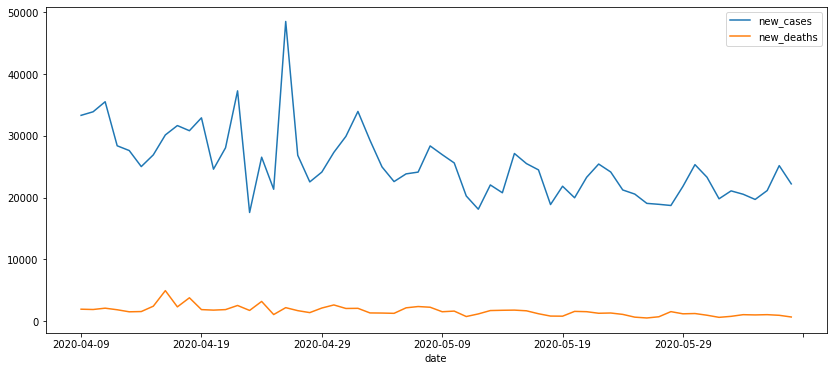

In [152]:
dfOwidUSA = dfOwid.loc[dfOwid.iso_code=='USA']

dfOwidUSA.set_index('date')[['new_cases','new_deaths']][-60:].plot.line(figsize=(14,6))

In [0]:
state = 'FL'
dfRollingWeekState = dfCovidtracking.loc[dfCovidtracking.state==state]\
.rolling(window=7).mean()


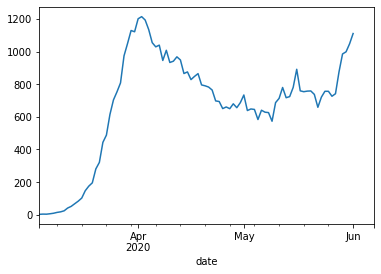

In [154]:
plt = dfRollingWeekState.positiveIncrease.plot.line()

In [155]:
dfJHUData[dfJHUData.state=='Florida'].confirmed.sum()

62758

In [0]:
doWGA = dfCovidtracking[dfCovidtracking.state=='GA'][['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']]\
.groupby(lambda x: x.dayofweek)

In [157]:
doWGA.sum()

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,318,1076,76553,5815,82368
1,466,1723,66032,8118,74150
2,371,1851,-11209,8635,-2574
3,349,1268,63977,7418,71395
4,336,1313,91942,8972,100914
5,203,1111,95506,6654,102160
6,137,343,105185,6284,111469


# Socrata (San Francisco) Data

In [158]:
!pip install sodapy

In [0]:
from sodapy import Socrata

In [0]:
client = Socrata("data.sfgov.org", "LCSuN5PrqWkGtBe9dULkS75Rz")
results_df = pd.DataFrame.from_records(client.get("tvq9-ec9w"))

In [161]:
results_df.case_disposition.unique()

array(['Confirmed', 'Death'], dtype=object)

In [0]:
res = results_df.astype({'case_count':'int16'})

In [0]:
dfresConf = res[res.case_disposition=='Confirmed']
dfresDead = res[res.case_disposition=='Death']

In [0]:
dfTotals = dfresConf.groupby(by='date').sum().join(dfresDead.groupby(by='date').sum(), \
        rsuffix='dead').fillna(0) \
        .rename(columns={'case_count':'positive', 'case_countdead':'dead'})

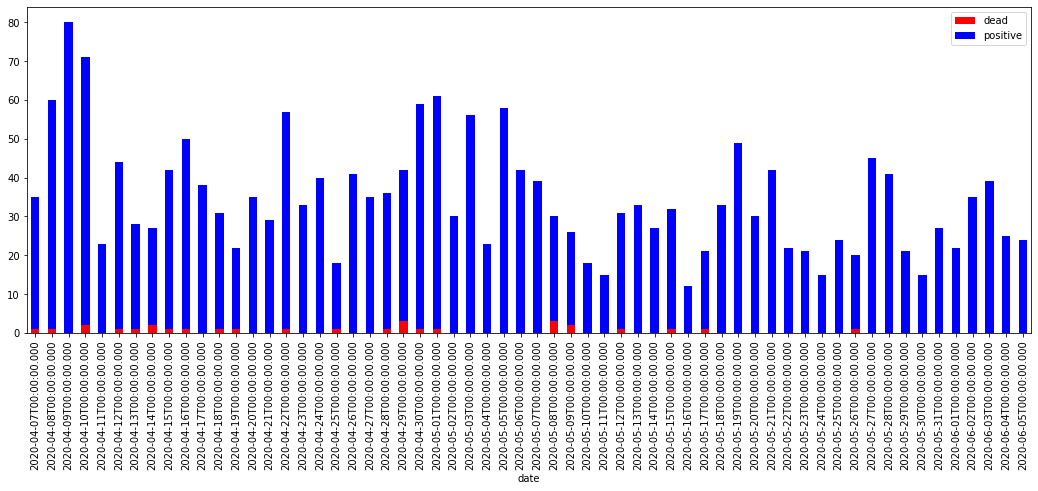

In [165]:
chart = dfTotals[['dead', 'positive']][-60:]\
.plot.bar(figsize=(18,6),stacked=True, color=['red','blue'])

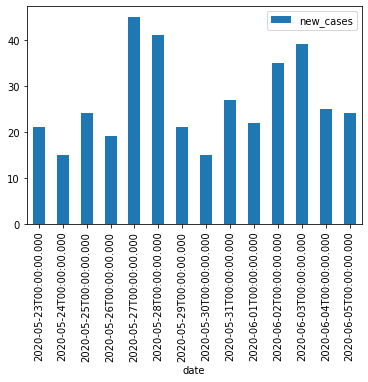

In [166]:
dfresConf.groupby('date').sum().rename(columns={'case_count':'new_cases'}).tail(14).plot.bar()

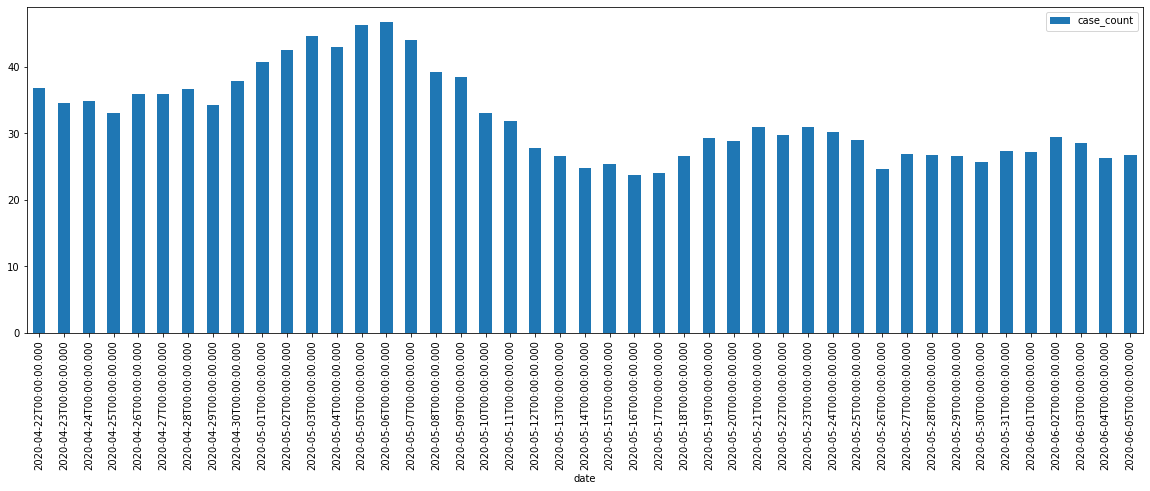

In [167]:
dfresConf.groupby('date').sum().rolling(window=7).mean()[-45:].plot.bar(figsize=(20,6))

# Marin Data

In [0]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSRmO2pStf7Ft1yYjDULluZXzUAczGK_B34hDemDBadGEY0HTLwlcadF2cHNEwmmvLetUTf-D2ruYCT/pub?gid=0&single=true&output=csv"

df = pd.read_csv(url, header=1, parse_dates=[0], usecols=[0,1,3,5,6,7], index_col=[0])

In [178]:
df.tail()

,positive,deaths,tested,hospitalizations,Recovered
date,,,,,
2020-06-03,525,17.0,14430.0,52.0,366.0
2020-06-04,530,17.0,14592.0,52.0,392.0
2020-06-05,551,17.0,15034.0,52.0,401.0
2020-06-06,571,17.0,15573.0,52.0,405.0
2020-06-07,589,17.0,15962.0,52.0,405.0


In [179]:
df[['deaths','positive']].diff()

,deaths,positive
date,,
2020-03-06,NaN,NaN
2020-03-07,0.0,0.0
2020-03-08,0.0,1.0
2020-03-09,0.0,0.0
2020-03-10,NaN,0.0
...,...,...
2020-06-03,0.0,19.0
2020-06-04,0.0,5.0
2020-06-05,0.0,21.0


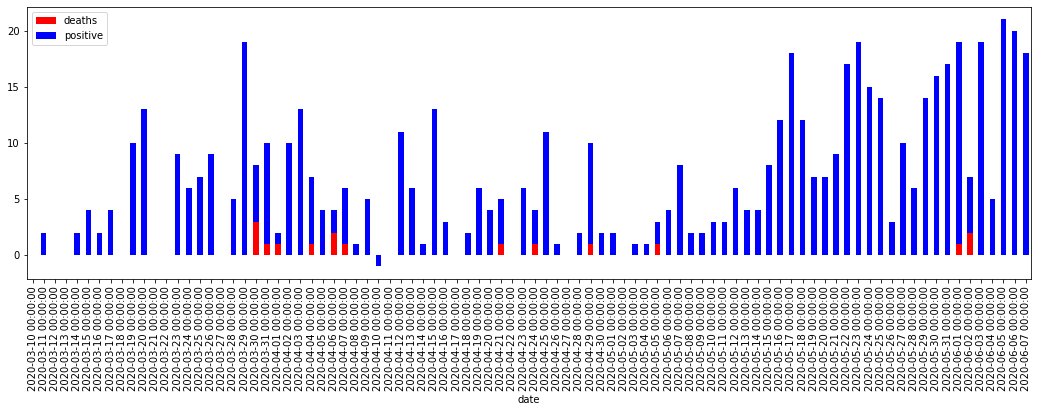

In [180]:
chart= df[['deaths','positive']].diff()[-90:]\
.plot.bar(stacked=True,figsize=(18,5), color=['r','b'])

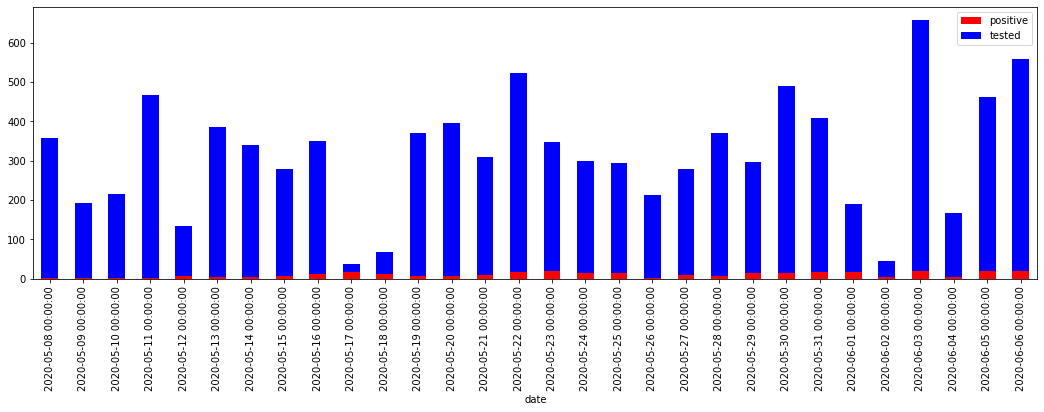

In [172]:
chart= df[['positive','tested']].diff()[-30:]\
.plot.bar(stacked=True,figsize=(18,5), color=['r','b'])

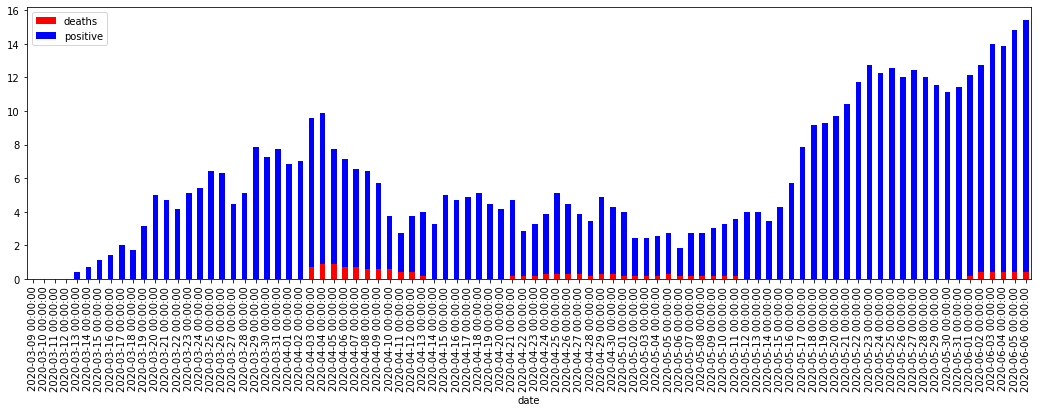

In [173]:
chart= df[['deaths','positive']].diff()\
.rolling(window=7).mean()[-90:]\
.plot.bar(stacked=True,figsize=(18,5), color=['r','b'])

In [174]:
marin_pop = 259725

print(f"Marin Population Positive: {(df[-1:].positive.values[0]/marin_pop)*100:2.2f}%")
print(f"Marin Population Tested: {(df[-1:].tested.values[0]/marin_pop)*100:2.2f}%")

Marin Population Positive: 0.22%
Marin Population Tested: 6.00%


In [175]:
df.positive.diff().rolling(window=7).mean().tail()

date
2020-06-02    12.285714
2020-06-03    13.571429
2020-06-04    13.428571
2020-06-05    14.428571
2020-06-06    15.000000
Name: positive, dtype: float64

In [176]:
dfCovidtracking[dfCovidtracking.state=='CA'].head(28)[::-1].positive.diff()


date
2020-05-11       NaN
2020-05-12    1443.0
2020-05-13    1759.0
2020-05-14    2023.0
2020-05-15    1772.0
2020-05-16    1857.0
2020-05-17    2046.0
2020-05-18    1591.0
2020-05-19    1365.0
2020-05-20    2262.0
2020-05-21    2140.0
2020-05-22    2247.0
2020-05-23    2187.0
2020-05-24    2079.0
2020-05-25    1848.0
2020-05-26    2175.0
2020-05-27    2247.0
2020-05-28    2717.0
2020-05-29    2189.0
2020-05-30    2992.0
2020-05-31    3705.0
2020-06-01    2423.0
2020-06-02    2304.0
2020-06-03    2377.0
2020-06-04    2120.0
2020-06-05    3094.0
2020-06-06    3115.0
2020-06-07    2796.0
Name: positive, dtype: float64